# GULP Calculations

The `gulp.single` (for single point energy calculations) and `gulp.optimize` (for geometry optimisation calculations) plugins will run the [General Utility Lattice Program (GULP)](http://gulp.curtin.edu.au/gulp/).
They are designed to create the input `.gin` file,
from a set of AiiDA :py:class:`~aiida.orm.nodes.data.Data` nodes.

.. note::

    It is likely that these calculations will eventually be moved to a separate repository.

## Initial Setup

To run a computation, first ensure AiiDA is running:

In [1]:
!verdi status

 ✓ profile:     On profile test_profile
 ✓ repository:  /var/folders/dm/b2qnkb_n3r72slmpxlfmcjvm00lbnd/T/tmpg8oec6ni/test_repo
 ✓ postgres:    Connected as aiida@localhost:63708
 ✓ rabbitmq:    Connected to amqp://127.0.0.1?heartbeat=600
 ✓ daemon:      Daemon is running as PID 50009 since 2019-08-12 12:06:45


.. seealso::

    AiiDA documentation: :ref:`aiida:quick_installation`

If `aiida-crystal17` is installed,
the `gulp.single` and `gulp.optimize` computations should be available:

In [2]:
!verdi plugin list aiida.calculations gulp.single

-/|\-/Inputs
           code:  required  Code                The Code to use for this job.
      potential:  required  EmpiricalPotential  parameters to create the potential section of the .gin file content.
      structure:  required  StructureData       atomic structure used to create the geometry section of .gin file content.
       metadata:  optional                      
     parameters:  optional  Dict                additional input parameters to create the .gin file content.
Outputs
  remote_folder:  required  RemoteData          Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict                the data extracted from the main output file
      retrieved:  required  FolderData          Files that are retrieved by the daemon will be stored in this node. By defa ...
Exit codes
              1:  The process has failed with an unspecified error.
              2:  The process failed with legacy failure mode.
      

In [3]:
!verdi plugin list aiida.calculations gulp.optimize

-/|\-/Inputs
           code:  required  Code                The Code to use for this job.
      potential:  required  EmpiricalPotential  parameters to create the potential section of the .gin file content.
      structure:  required  StructureData       atomic structure used to create the geometry section of .gin file content.
       metadata:  optional                      
     parameters:  optional  Dict                additional input parameters to create the .gin file content.
       symmetry:  optional  SymmetryData        parameters to create the symmetry section of the .gin file content (for con ...
Outputs
  remote_folder:  required  RemoteData          Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict                the data extracted from the main output file
      retrieved:  required  FolderData          Files that are retrieved by the daemon will be stored in this node. By defa ...
      structure:  re

To use the python interface,
first ensure a profile is loaded in the python kernel,
and import the required modules:

In [1]:
from aiida import load_profile
profile = load_profile()
profile.name

'test_crystal17'

In [2]:
import os
from aiida.orm import Code
from aiida.plugins import (
    DataFactory, WorkflowFactory, CalculationFactory)
from aiida.engine import run_get_node
from aiida_crystal17.common import display_json
from aiida.tools.visualization import Graph
from jsonextended import edict

## Input Node Creation

.. seealso::

    [GULP Help File](http://gulp.curtin.edu.au/gulp/help/help_45_txt.html)

### Code

.. seealso::

    AiiDA documentation: :ref:`aiida:setup_code`

An :py:class:aiida.orm.nodes.data.code.Code node should be set up in advance, to use the gulp calculation plugin, and call the gulp executable (or mock_gulp used here for test purposes).

In [6]:
from aiida_crystal17.tests.utils import get_or_create_local_computer, get_or_create_code
computer = get_or_create_local_computer('work_directory', 'localhost')
code_single = get_or_create_code('gulp.single', computer, 'mock_gulp')
code_opt = get_or_create_code('gulp.optimize', computer, 'mock_gulp')
code_opt.get_full_text_info()

[['PK', 2],
 ['UUID', 'ef6cbd4d-c088-4948-b0a4-5e9235ca990a'],
 ['Label', 'gulp.optimize-mock_gulp@localhost'],
 ['Description', ''],
 ['Default plugin', 'gulp.optimize'],
 ['Type', 'remote'],
 ['Remote machine', 'localhost'],
 ['Remote absolute path', '//anaconda/envs/aiida_crystal17/bin/mock_gulp'],
 ['Prepend text', 'No prepend text'],
 ['Append text', 'No append text']]

.. note::

    The calculations are tested against GULP v4.5.3

### Atomic Structure

The ``structure`` refers to a standard
:py:class:`~aiida.StructureData` node, and is used to create the `main.gui`.

Structures consist of:

- A cell with a basis vectors and whether it is periodic, for each dimension
- ``Site`` with a cartesian coordinate and reference to a kind
- ``Kind`` which details the species and composition at one or more sites

The simplest way to create a structure is *via* :py:mod:`ase`:

In [7]:
from ase.spacegroup import crystal
atoms = crystal(
    symbols=[12, 8],
    basis=[[0, 0, 0], [0.5, 0.5, 0.5]],
    spacegroup=225,
    cellpar=[4.21, 4.21, 4.21, 90, 90, 90])
struct_cls = DataFactory('structure')
structure = struct_cls(ase=atoms)
structure

<StructureData: uuid: 760eaf3d-0336-49d1-b1db-5b665615c85f (unstored)>

These structures can be visualised using standard ASE methods.

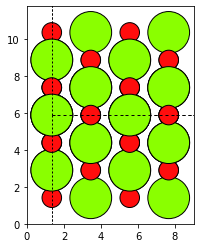

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
atoms = structure.get_ase()
fig, ax = plt.subplots()
plot_atoms(atoms.repeat((2,2,2)), 
           ax, radii=0.8, show_unit_cell=True, 
           rotation=('45x,0y,0z'));

As default, one kind is created per atomic species
(named as the atomic symbol):

In [9]:
structure.get_site_kindnames()

['Mg', 'Mg', 'Mg', 'Mg', 'O1', 'O1', 'O1', 'O1']

However, we may want to specify more than one kind per species (for example to setup anti-ferromagnetic spin). We can achieve this by tagging the atoms:

In [10]:
atoms_afm = atoms.copy()
atoms_afm.set_tags([1, 1, 2, 2, 0, 0, 0, 0])
structure_afm = struct_cls(ase=atoms_afm)
structure_afm.get_site_kindnames()

['Mg1', 'Mg1', 'Mg2', 'Mg2', 'O', 'O', 'O', 'O']

### Inter-Atomic Potential

Inter-atomic potentials are supplied in the form of a py:class:`~aiida.orm.nodes.data.dict.Dict` node with keys `pair_style` and `data`, with the form of the `data` dictated by the pair_style.
Pair styles are created by sub-classing :py:class:`~aiida_crystal17.gulp.potentials.base.PotentialWriterAbstract` and adding an entry point to `gulp.potentials`. Available pair styles and data schema can be found by:

In [11]:
!verdi data gulp.potentials list

Registered entry points for gulp.potentials:
* lj
* reaxff

Info: Pass the entry point as an argument to display detailed information


In [12]:
!verdi data gulp.potentials list lj -d 8

Lennard-Jones potential, of the form; E = A/r**m - B/r**n
Data Schema:
$id: potential.base.schema
$schema: http://json-schema.org/draft-07/schema
description: a schema for storing an empirical potential
properties: 
  2body: 
    additionalProperties: False
    description: parameters that depend on two species
    patternProperties: 
      [0-9]+\-[0-9]+: 
        description: mapping of '<idx1>-<idx2>' to properties
        properties: 
          lj_A: 
            description: fist coefficient (in ev*Angs**m)
            type: number
          lj_B: 
            description: second coefficient (in ev*Angs**m)
            type: number
          lj_m: 
            default: 12
            description: first exponent
            exclusiveMinimum: 0
            type:    integer
          lj_n: 
            default: 6
            description: second exponent
            exclusiveMinimum: 0
            type:    integer
          lj_rmax: 
            description: maximum radius cut-off (An

In [13]:
from aiida.plugins import load_entry_point
writer = load_entry_point('gulp.potentials', 'lj')()
data = {
    "species": ["H core", "He core"],
    "2body": {
        "0-1": {
            "lj_A": 1.0,
            "lj_B": 2.0,
            "lj_rmax": 12.0
        }
    }
}
content = writer.create_content(data)
print("Number of fitted parameters:", content.number_of_flags)
print(content.content)

Number of fitted parameters: 2
lennard 12 6
H core  He core 1.00000000E+00 2.00000000E+00 12.00000


ReaxFF data can be created from the standard LAMMPS style potential file, using

In [14]:
from aiida_crystal17.tests import read_resource_text
from aiida_crystal17.gulp.potentials.raw_reaxff import read_lammps_format
from aiida_crystal17.gulp.potentials.common import filter_by_species

data = read_lammps_format(read_resource_text('gulp', 'potentials', 'FeCrOSCH.reaxff').splitlines())
data = filter_by_species(data, ["Fe core", "S core"])

edict.pprint(data, depth=2, keycolor='blue')

1body:
  0: {...}
  1: {...}
2body:
  0-0: {...}
  0-1: {...}
  1-1: {...}
3body:
  0-0-1: {...}
  0-1-0: {...}
  0-1-1: {...}
  1-0-1: {...}
  1-1-1: {...}
4body:
  1-1-1-1: {...}
description: Reactive MD-force field: Cr/O/Fe/S/C/H force field 2014
global:
  C2-correction:           60.485
  Lower Taper-radius:      0.0
  Not used 2:              6.1431
  Not used 3:              -2.4837
  Not used 4:              -1.2327
  Not used 5:              0.5
  Not used 6:              20.0
  Not used 7:              5.0
  Not used 8:              0.0
  Triple bond stabilisation: 4.6
  Triple bond stabilisation 1: 1.7224
  Triple bond stabilisation 2: 6.8702
  Triple bond stabilization energy: -70.5044
  Upper Taper-radius:      10.0
  bond order cutoff:       0.1
  reaxff0_boc1:            50.0
  reaxff0_boc2:            9.5469
  reaxff0_cot2:            2.1645
  reaxff0_lp1:             6.0891
  reaxff0_ovun3:           50.0
  reaxff0_ovun4:           0.6991
  reaxff0_ovun6:           1.05

## Setting Up and Running the Calculations

.. seealso::

    AiiDA documentation: :ref:`aiida:working_processes`

In [15]:
from aiida_crystal17.symmetry import convert_structure
structure_data = {
    "lattice": [[5.38, 0.000000, 0.000000],
                [0.000000, 5.38, 0.000000],
                [0.000000, 0.000000, 5.38]],
    "fcoords": [[0.0, 0.0, 0.0], [0.5, 0.0, 0.5], [0.0, 0.5, 0.5],
                [0.5, 0.5, 0.0], [0.338, 0.338, 0.338],
                [0.662, 0.662, 0.662], [0.162, 0.662, 0.838],
                [0.838, 0.338, 0.162], [0.662, 0.838, 0.162],
                [0.338, 0.162, 0.838], [0.838, 0.162, 0.662],
                [0.162, 0.838, 0.338]],
    "symbols": ['Fe'] * 4 + ['S'] * 8,
    "pbc": [True, True, True]
}
structure = convert_structure(structure_data, "aiida")
structure

<StructureData: uuid: c1bfe430-3fed-4a13-90e9-50595cfb0230 (unstored)>

In [16]:
potential_data = {
    "species": ["Fe core", "S core"],
    "2body": {
        "0-0": {
            "lj_A": 1.0,
            "lj_B": 1.0,
            "lj_rmax": 12.0
        },
        "0-1": {
            "lj_A": 1.0,
            "lj_B": 1.0,
            "lj_rmax": 12.0
        },
        "1-1": {
            "lj_A": 1.0,
            "lj_B": 1.0,
            "lj_rmax": 12.0
        }
    }
}
potential_lj = DataFactory('gulp.potential')(
    pair_style="lj", potential_data=potential_data)
potential_lj.attributes

{'pair_style': 'lj',
 'description': 'Lennard-Jones potential, of the form; E = A/r**m - B/r**n',
 'species': ['Fe core', 'S core'],
 'input_lines_md5': '35449283e18a3393ba70f925a16ba6a5',
 'fitting_flags': False,
 'total_flags': 6,
 'number_flagged': 0,
 'potential_filename': 'potential.pot',
 'potential_json': 'potential.json',
 'fitting_json': 'fitting.json'}

### gulp.single

In [17]:
code_single = Code.objects.get(
    label="gulp.single-mock_gulp@localhost")
builder = code_single.get_builder()
builder.metadata.options = {
    "resources": {
        "num_machines": 1, 
        "num_mpiprocs_per_machine": 1}}
builder.structure = structure
builder.potential = potential_lj

In [18]:
result, calcnode = run_get_node(builder)
calcnode

<CalcJobNode: uuid: dd55a58a-f4cc-4596-8db8-f5e2404046d0 (pk: 5) (aiida.calculations:gulp.single)>

In [19]:
print(calcnode.is_finished_ok)
print(calcnode.process_state)
print(calcnode.exit_status)

True
ProcessState.FINISHED
0


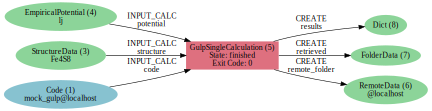

In [20]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode)
graph.add_incoming(calcnode, annotate_links="both")
graph.add_outgoing(calcnode, annotate_links="both")
graph.graphviz

### gulp.optimize

In [21]:
opt_dict={
    "minimize": {"style": "cg", "max_iterations": 100},
    "relax": {"type": "conp"}}
opt_params = DataFactory('dict')(dict=opt_dict)
opt_params

<Dict: uuid: 72dad977-2bbb-462c-89f2-dfe3ef075aa8 (unstored)>

In [22]:
code_opt = Code.objects.get(
    label="gulp.optimize-mock_gulp@localhost")
builder_opt = code_opt.get_builder()
builder_opt.metadata.options = {
    "resources": {
        "num_machines": 1, 
        "num_mpiprocs_per_machine": 1}}
builder_opt.structure = structure
builder_opt.potential = potential_lj
builder_opt.parameters = opt_params

In [23]:
result, calcnode_opt = run_get_node(builder_opt)
calcnode_opt

<CalcJobNode: uuid: 1d2c3a42-f732-494d-8e01-1f4ed9b59bfb (pk: 10) (aiida.calculations:gulp.optimize)>

In [24]:
print(calcnode_opt.is_finished_ok)
print(calcnode_opt.process_state)
print(calcnode_opt.exit_status)

True
ProcessState.FINISHED
0


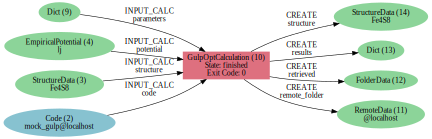

In [25]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode_opt)
graph.add_incoming(calcnode_opt, annotate_links="both")
graph.add_outgoing(calcnode_opt, annotate_links="both")
graph.graphviz

In [26]:
display_json(calcnode_opt.outputs.results.attributes)

```json
{
  "errors": [],
  "opt_type": "bulk",
  "warnings": [],
  "energy_units": "eV",
  "final_energy": -17.47113113,
  "gulp_version": "4.5.3",
  "parser_class": "GulpOptParser",
  "opt_succeeded": true,
  "parser_errors": [],
  "initial_energy": -0.32809466,
  "parser_version": "0.10.0b5",
  "opt_time_second": 0.3676,
  "parser_warnings": [],
  "total_time_second": 0.3677,
  "final_primitive_energy": -17.47113113,
  "peak_dynamic_memory_mb": 0.54,
  "initial_primitive_energy": -0.32809466
}
```